In [52]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE
from torch.optim import lr_scheduler
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
# Load and prepare the data
df = pd.read_csv(r"C:\Users\andre\Downloads\archive\healthcare-dataset-stroke-data.csv")

# Remove samples where gender is "Other"
df = df[df['gender'] != 'Other']

# Handle missing values
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

# Convert categorical variables to numeric
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})  
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
work_type_dummies = pd.get_dummies(df['work_type'], drop_first=True)
df = pd.concat([df.drop('work_type', axis=1), work_type_dummies], axis=1)
df['Residence_type'] = df['Residence_type'].map({'Rural': 0, 'Urban': 1})
smoking_status_dummies = pd.get_dummies(df['smoking_status'], drop_first=True)
df = pd.concat([df.drop('smoking_status', axis=1), smoking_status_dummies], axis=1)

# Select features
features = ['age', 'gender', 'hypertension', 'heart_disease', 'ever_married',
           'Residence_type', 'avg_glucose_level', 'bmi',
           'Private', 'Self-employed', 'children', 'Never_worked',  # work_type features
           'formerly smoked', 'never smoked', 'smokes']  # smoking_status features
X = df[features]
y = df['stroke']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  w

Accuracy: 0.7407

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.17      0.81      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.77      0.56      1022
weighted avg       0.93      0.74      0.81      1022



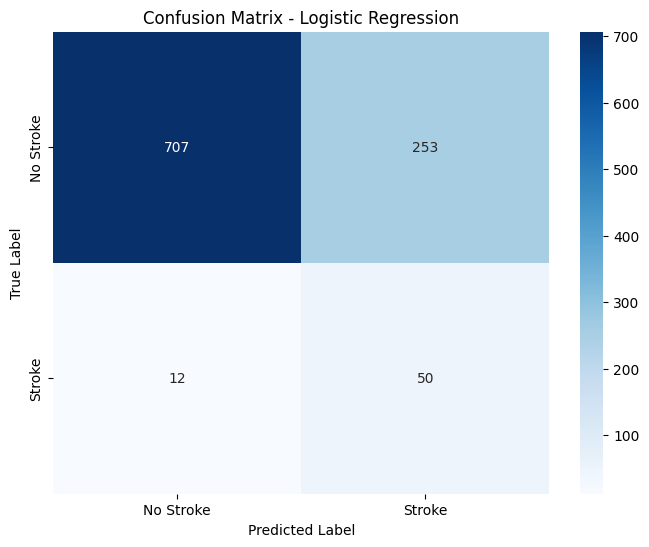


Feature Importance:
              Feature  Importance
0                 age    2.111724
10           children    0.597542
6   avg_glucose_level    0.217856
8             Private    0.146980
14             smokes    0.113803
2        hypertension    0.098446
1              gender    0.057844
3       heart_disease    0.037269
7                 bmi    0.010567
5      Residence_type    0.003038
4        ever_married   -0.022664
12    formerly smoked   -0.065747
9       Self-employed   -0.074592
11       Never_worked   -0.100015
13       never smoked   -0.130751


In [54]:
# logistic regression
# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_binary = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Create and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
# Print feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.coef_[0]
})
print("\nFeature Importance:")
print(feature_importance.sort_values(by='Importance', ascending=False))

In [55]:
# Convert numpy arrays to PyTorch tensors
X_train_balanced = torch.FloatTensor(X_train_balanced)
y_train_balanced = torch.FloatTensor(y_train_balanced)
X_test_scaled = torch.FloatTensor(X_test_scaled)
y_test = torch.FloatTensor(y_test.values)

In [56]:
# Create PyTorch Dataset
class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 1. Add ResNet block class
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out

# 2. Modified model with ResNet blocks
class StrokePredictor(nn.Module):
    def __init__(self, input_dim):
        super(StrokePredictor, self).__init__()
        
        # Initial layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        # ResNet blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(512),
            ResidualBlock(512),
            ResidualBlock(512)
        )
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_blocks(x)
        x = self.output_layers(x)
        return x
# Create data loaders
train_dataset = StrokeDataset(X_train_balanced, y_train_balanced)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Add this before model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights more precisely
class_weights = torch.FloatTensor([1.0, 12.0]).to(device)
criterion = nn.BCELoss(weight=class_weights[1])

# Initialize model with improved optimizer settings
model = StrokePredictor(len(features)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.005)

# Define num_epochs first
num_epochs = 100

# Move scheduler initialization after num_epochs definition
scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                  max_lr=0.001,
                                  epochs=num_epochs,
                                  steps_per_epoch=len(train_loader),
                                  pct_start=0.2)

# Add validation set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32)

# Training loop with early stopping
best_loss = float('inf')
patience_counter = 0
early_stopping_patience = 15

# Modify training loop with gradient accumulation
accumulation_steps = 4

In [57]:
# 3. Modified training loop with detailed monitoring
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            total_loss += loss.item()
            
            preds = (outputs.squeeze() > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, all_preds)
    
    return avg_loss, f1, accuracy

# Modified training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    
    for i, (batch_X, batch_y) in enumerate(train_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss = loss / accumulation_steps
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        train_loss += loss.item()
    
    # Print detailed metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_train_loss, train_f1, train_acc = evaluate_model(model, train_loader, criterion, device)
        avg_val_loss, val_f1, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print("-" * 50)
        print(f"Training   - Loss: {avg_train_loss:.4f}, F1: {train_f1:.4f}, Acc: {train_acc:.4f}")
        print(f"Validation - Loss: {avg_val_loss:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}")
    
    # Early stopping check
    avg_val_loss, _, _ = evaluate_model(model, val_loader, criterion, device)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

# Modified evaluation
def evaluate_with_threshold_tuning(model, X_test, y_test, thresholds=np.arange(0.1, 0.9, 0.1)):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.to(device)).cpu().numpy()
    
    # Convert y_test to numpy array first
    y_test_numpy = y_test.cpu().numpy()
    
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (predictions > threshold).astype(int)
        f1 = f1_score(y_test_numpy, y_pred)  # Now both are numpy arrays
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

# Find best threshold and evaluate
best_threshold = evaluate_with_threshold_tuning(model, X_test_scaled, y_test)

# Final evaluation with best threshold
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_scaled.to(device)).cpu().numpy()
    y_pred = (test_predictions > best_threshold).astype(int)


Epoch [10/100]
--------------------------------------------------
Training   - Loss: 3.3343, F1: 0.8946, Acc: 0.8831
Validation - Loss: 3.2866, F1: 0.8957, Acc: 0.8872

Epoch [20/100]
--------------------------------------------------
Training   - Loss: 2.4339, F1: 0.9205, Acc: 0.9137
Validation - Loss: 2.4641, F1: 0.9189, Acc: 0.9141

Epoch [30/100]
--------------------------------------------------
Training   - Loss: 2.3381, F1: 0.9223, Acc: 0.9158
Validation - Loss: 2.4829, F1: 0.9179, Acc: 0.9128

Epoch [40/100]
--------------------------------------------------
Training   - Loss: 1.7202, F1: 0.9441, Acc: 0.9417
Validation - Loss: 1.7155, F1: 0.9424, Acc: 0.9410

Epoch [50/100]
--------------------------------------------------
Training   - Loss: 1.7036, F1: 0.9438, Acc: 0.9408
Validation - Loss: 1.7353, F1: 0.9434, Acc: 0.9417

Epoch [60/100]
--------------------------------------------------
Training   - Loss: 1.3653, F1: 0.9552, Acc: 0.9532
Validation - Loss: 1.3604, F1: 0.9541


Model Evaluation Results:
--------------------------------------------------
Best Classification Threshold: 0.100

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       960
         1.0       0.09      0.19      0.13        62

    accuracy                           0.84      1022
   macro avg       0.52      0.54      0.52      1022
weighted avg       0.89      0.84      0.86      1022


Confusion Matrix:


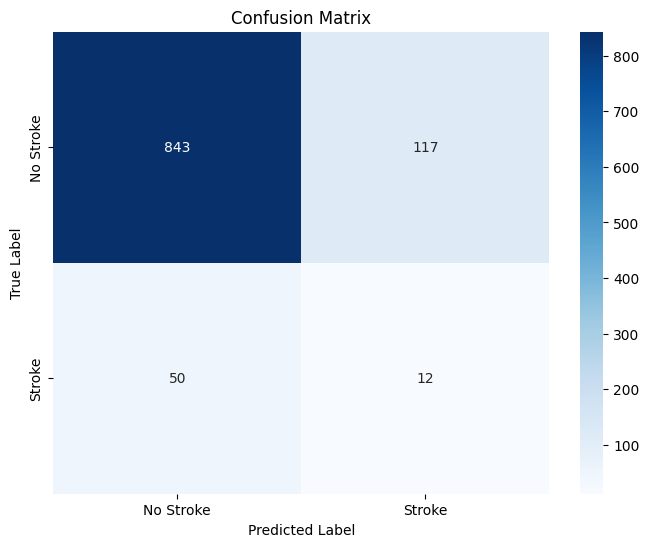


Detailed Metrics:
Accuracy Score: 0.837
F1 Score: 0.126


In [58]:
# Print evaluation metrics
print("\nModel Evaluation Results:")
print("-" * 50)
print(f"Best Classification Threshold: {best_threshold:.3f}")

# Convert y_test to numpy array once for all metrics
y_test_numpy = y_test.cpu().numpy()

print("\nClassification Report:")
print(classification_report(y_test_numpy, y_pred))
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_numpy, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print("\nDetailed Metrics:")
print(f"Accuracy Score: {accuracy_score(y_test_numpy, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test_numpy, y_pred):.3f}")

# FocalLoss class remains the same
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)

# Use focal loss instead of BCE
criterion = FocalLoss(alpha=2, gamma=3)